In [1]:
from vnstock import *
from function import *
from operators import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests

##### VN30

In [3]:
x='2023-02-16'
ticket = ['ACB', 'BCM', 'BID', 'BVH', 'CTG', 'FPT', 'GAS', 'GVR', 'HDB', 'HPG', 'MBB', 'MSN', 'MWG', 'NVL', 'PDR', 'PLX', 'POW', 'SAB', 'SSI', 'STB', 'TCB', 'TPB', 'VCB', 'VHM', 'VIB', 'VIC', 'VJC', 'VNM', 'VPB', 'VRE']
frame = []
for i in ticket:
    a = stock_historical_data(symbol=i, 
                            start_date=x,
                            end_date=x)
    a["ticker"] = i
    frame.append(a)
    
q = pd.concat(frame)
close= q.pivot_table(values="Close", columns="ticker", index="TradingDate")
high= q.pivot_table(values="High", columns="ticker", index="TradingDate")
low= q.pivot_table(values="Low", columns="ticker", index="TradingDate")
open= q.pivot_table(values="Open", columns="ticker", index="TradingDate")
volume = q.pivot_table(values="Volume", columns="ticker", index="TradingDate")

In [4]:
close= close.to_csv("Data/close.csv",mode="a",header=False)
high= high.to_csv("Data/high.csv",mode="a",header=False)
low= low.to_csv("Data/low.csv",mode="a",header=False)
open= open.to_csv("Data/open.csv",mode="a",header=False)
volume= volume.to_csv("Data/volume.csv",mode="a",header=False)

In [2]:
close= pd.read_csv("Data/close.csv",index_col="TradingDate")
close.index = pd.to_datetime(close.index)
high= pd.read_csv("Data/high.csv",index_col="TradingDate")
high.index = pd.to_datetime(high.index)
low= pd.read_csv("Data/low.csv",index_col="TradingDate")
low.index = pd.to_datetime(low.index)
open= pd.read_csv("Data/open.csv",index_col="TradingDate")
open.index = pd.to_datetime(open.index)
volume= pd.read_csv("Data/volume.csv",index_col="TradingDate")
volume.index = pd.to_datetime(open.index)

returns = close.pct_change()

### Prob weight model

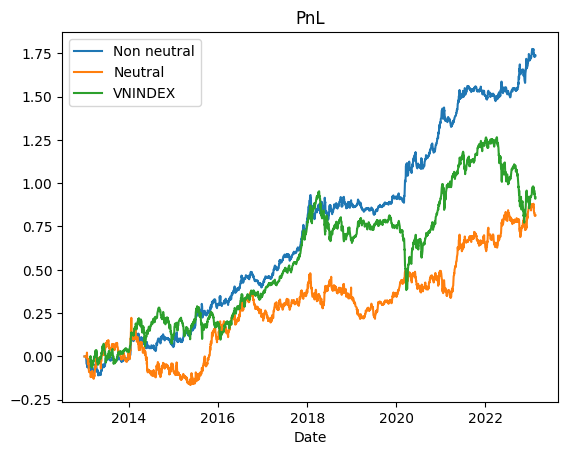

In [5]:
prob = prob_weights(close,10)

w = weights(prob,neutrali=0)
w1 = weights(prob,neutrali=1)

a = Simresult(w,returns=returns)
a.plot_pnl("Non neutral")

b = Simresult(w1,returns=returns)
b.plot_pnl("Neutral")

plot_vnindex()

In [6]:
a.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.173284,1.246683,0.378375,0.843672,457.967369


### Markowitz model

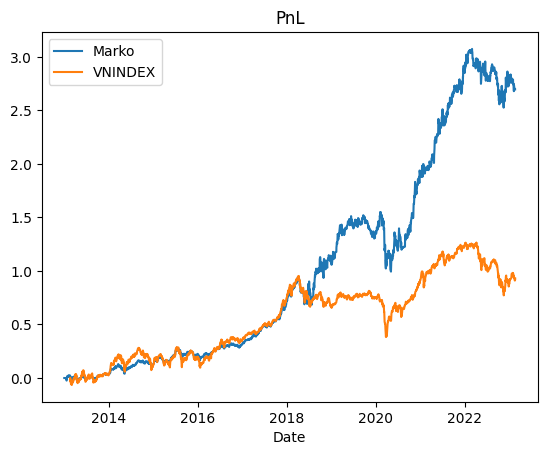

In [6]:
mark = marko_weights(close,lag=10)
a = Simresult(mark,returns=close.pct_change())
a.plot_pnl("Marko")

plot_vnindex()

In [7]:
a.get_summary()

,Return,Sharpe,Turnover,Fitness,Margin
TradingDate,,,,,
2013,0.037903,0.521421,0.000000,0.287124,inf
2014,0.091851,1.054659,0.000000,0.904066,inf
2015,0.093926,0.960856,0.000000,0.832907,inf
2016,0.098835,1.235096,0.000000,1.098247,inf
2017,0.396302,4.764245,0.000000,8.483056,inf
2018,0.408062,0.991476,0.095467,1.791391,4274.389310
2019,0.256358,0.918631,0.200000,1.040039,1281.791139
2020,0.545455,1.140511,0.174603,2.015825,3123.971292
2021,0.981200,2.277145,0.182531,5.279598,5375.519063


### alpha1 = close-ts_product(close,2)^0.5

In [10]:
alpha4 = close-ts_product(close,2)**0.5

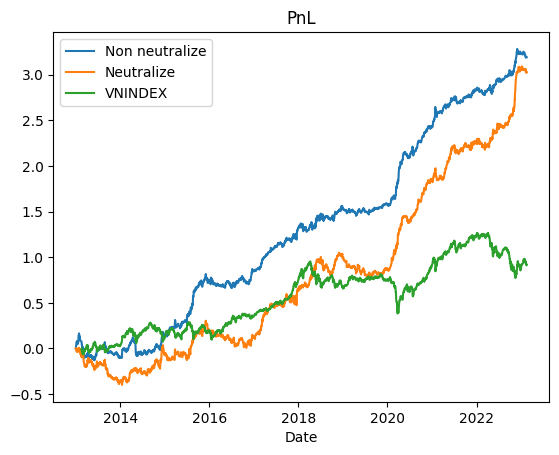

In [11]:
w = weights(alpha4,neutrali=0)
w1 =weights(alpha4,neutrali=1)

returns = close.pct_change()
a = Simresult(w,returns)
a.plot_pnl("Non neutralize")

b = Simresult(w1,returns)
b.plot_pnl("Neutralize")

plot_vnindex()

### alpha2=ts_zscore(close,2)

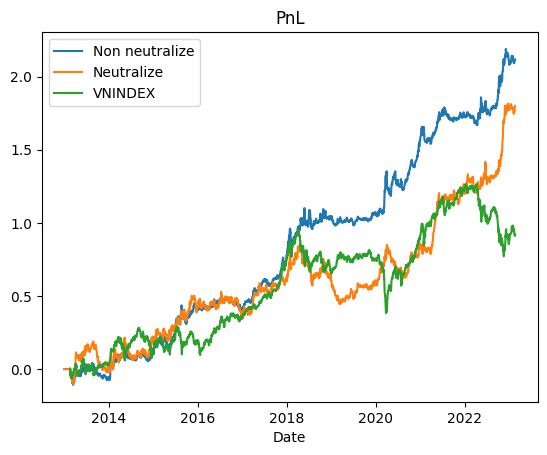

In [4]:
alpha7 = ts_zscore(close,30)
w =weights(alpha7, neutrali=0)
w1 =weights(alpha7,neutrali=1)

returns = close.pct_change()
a = Simresult(w,returns)
a.plot_pnl("Non neutralize")

b = Simresult(w1,returns)
b.plot_pnl("Neutralize")

plot_vnindex()

In [5]:
a.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.211438,1.235484,0.331841,0.986195,637.164311


### Merge alpha

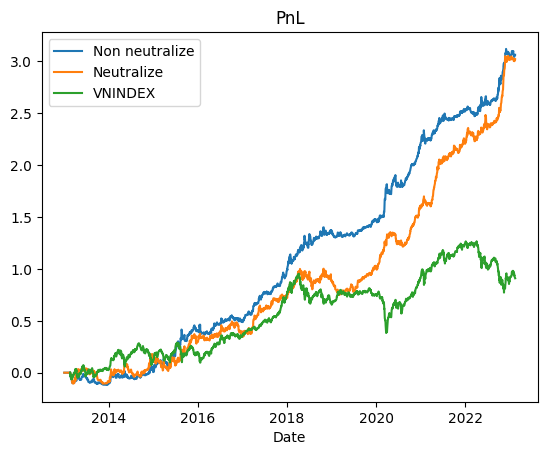

In [8]:
alpha = (0.4*alpha7+0.4*ts_zscore(close,2))
w =weights(alpha, neutrali=0)
w1 =weights(alpha,neutrali=1)

returns = close.pct_change()
a = Simresult(w,returns)
a.plot_pnl("Non neutralize")

b = Simresult(w1,returns)
b.plot_pnl("Neutralize")

plot_vnindex()

In [15]:
save_weights(w1,"14/2/2023")

volume/adv20

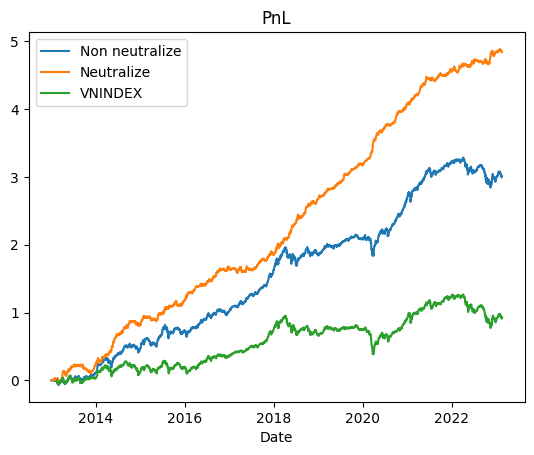

In [14]:
alpha5 = rank(volume/ts_mean(volume,20))
w =weights(alpha5, neutrali=0)
w1 =weights(alpha5,neutrali=1)

returns = close.pct_change()
a = Simresult(w,returns)
a.plot_pnl("Non neutralize")

b = Simresult(w1,returns)
b.plot_pnl("Neutralize")

plot_vnindex()

In [15]:
b.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.482892,3.107153,1.942803,1.549078,248.554406


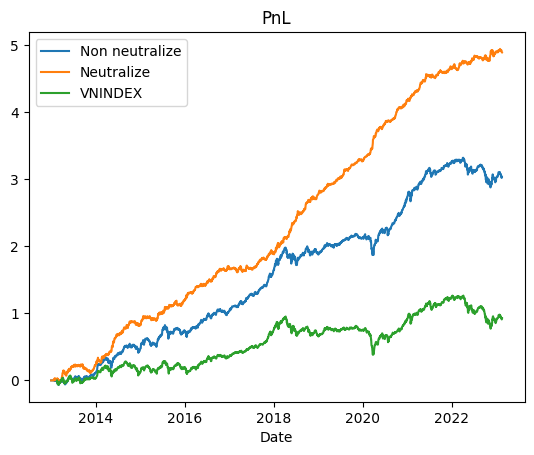

In [16]:
s = ts_sum(close,20)/20
le1 = s * 0.95
le2 = s * 0.9
le3 = s * 0.85
le4 = s * 0.8
le5 = s * 0.75
le6 = s * 0.70
alpha = trade_when(low < le6,alpha5 + 0.5*abs(alpha5),
                   trade_when(low < le5,alpha5 + 0.4*abs(alpha5),
                              trade_when(low < le4,alpha5 + 0.32*abs(alpha5),
                                         trade_when(low < le3,alpha5 + 0.25*abs(alpha5),
                                                    trade_when(low < le2,alpha5 + 0.2*abs(alpha5),
                                                               trade_when(low < le1,alpha5+0.1*abs(alpha5),alpha5)
                                                               )
                                                    )
                                         )
                              )
                   )
w =weights(alpha, neutrali=0)
w1 =weights(alpha,neutrali=1)

returns = close.pct_change()
a = Simresult(w,returns)
a.plot_pnl("Non neutralize")

b = Simresult(w1,returns)
b.plot_pnl("Neutralize")

plot_vnindex()

In [17]:
b.get_overall()

,Return,Sharpe,Turnover,Fitness,Margin
0,0.488501,3.110156,1.941673,1.560008,251.587641


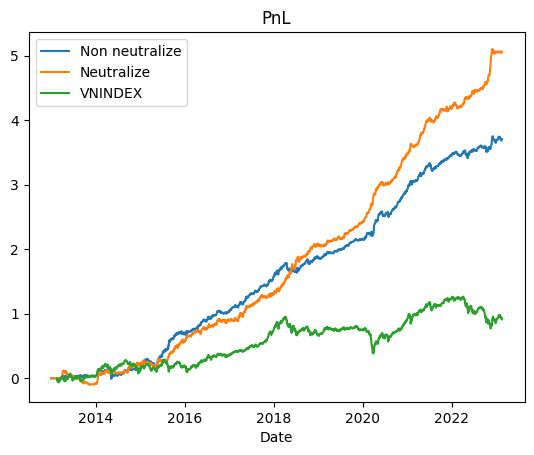

In [15]:
alpha = alpha5
w =weights(alpha, neutrali=0)
w1 =weights(alpha,neutrali=1)

returns = close.pct_change()
a = Simresult(w,returns)
a.plot_pnl("Non neutralize")

b = Simresult(w1,returns)
b.plot_pnl("Neutralize")

plot_vnindex()

In [16]:
b.get_summary()

,Return,Sharpe,Turnover,Fitness,Margin
TradingDate,,,,,
2013,-0.079257,-0.701393,0.431121,-0.300732,-183.838762
2014,0.275739,1.710404,1.114731,0.850674,247.359484
2015,0.376545,2.028663,1.666807,0.964219,225.908075
2016,0.325063,2.105453,1.600252,0.948931,203.132188
2017,0.431728,2.942717,2.157105,1.316491,200.142188
2018,0.746743,3.576431,2.193391,2.086783,340.451235
2019,0.368164,3.394214,2.149165,1.404834,171.305631
2020,1.064635,6.699715,2.135810,4.730156,498.469136
2021,0.697612,4.070791,2.267677,2.257851,307.633107


In [11]:
w1.iloc[-1,:][w1.iloc[-1,:]<0].sum()

-1.0

In [12]:
save_weights(w1,x)

In [25]:
save_weights(w1,"15/2/2023")

In [27]:
if (returns > 0).any(axis=None):
    returns = 1
else:
    returns = -1

returns


1

In [11]:
returns = close.pct_change()
bl = pd.DataFrame(np.nan, index=returns.index, columns=returns.columns)

In [20]:
bl[bl.columns] = np.where(returns>0,rank(close),0)

In [21]:
bl

,ACB,BCM,BID,BVH,CTG,FPT,GAS,GVR,HDB,HPG,...,TCB,TPB,VCB,VHM,VIB,VIC,VJC,VNM,VPB,VRE
TradingDate,,,,,,,,,,,,,,,,,,,,,
2013-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-03,0.000000,0.000000,0.000000,0.923077,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.538462,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-04,0.153846,0.000000,0.000000,0.923077,0.461538,0.384615,0.846154,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.538462,0.000000,0.000000,0.000000,0.000000,0.769231,0.000000,0.000000
2013-01-07,0.000000,0.000000,0.000000,0.923077,0.461538,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.538462,0.000000,0.000000,0.692308,0.000000,0.000000,0.000000,0.000000
2013-01-08,0.000000,0.000000,0.000000,0.923077,0.461538,0.384615,0.846154,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.538462,0.000000,0.000000,0.692308,0.000000,0.769231,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-10,0.000000,0.000000,0.000000,0.689655,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.896552,0.655172,0.000000,0.000000,0.931034,0.758621,0.000000,0.000000
2023-02-13,0.000000,0.000000,0.637931,0.000000,0.517241,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.931034,0.000000,0.000000,0.482759
2023-02-14,0.000000,0.827586,0.000000,0.689655,0.000000,0.793103,0.000000,0.103448,0.000000,0.310345,...,0.448276,0.344828,0.000000,0.000000,0.275862,0.000000,0.000000,0.000000,0.000000,0.000000


In [49]:
returns = returns.applymap(lambda x: 1 if x > 0 else close.loc[returns.index, returns.columns])


In [50]:
returns

,ACB,BCM,BID,BVH,CTG,FPT,GAS,GVR,HDB,HPG,...,TCB,TPB,VCB,VHM,VIB,VIC,VJC,VNM,VPB,VRE
TradingDate,,,,,,,,,,,,,,,,,,,,,
2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,-0.017191,NaN,NaN,1.000000,-0.009422,-0.013845,0.000000,NaN,NaN,1.000000,...,NaN,NaN,1.000000,NaN,NaN,0.000000,NaN,-0.005748,NaN,NaN
2013-01-04,1.000000,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,...,NaN,NaN,1.000000,NaN,NaN,0.000000,NaN,1.000000,NaN,NaN
2013-01-07,0.000000,NaN,NaN,1.000000,1.000000,-0.005477,0.000000,NaN,NaN,1.000000,...,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN,0.000000,NaN,NaN
2013-01-08,0.000000,NaN,NaN,1.000000,1.000000,1.000000,1.000000,NaN,NaN,1.000000,...,NaN,NaN,1.000000,NaN,NaN,1.000000,NaN,1.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-10,-0.012245,-0.002361,-0.023864,1.000000,-0.010204,0.000000,-0.018501,-0.020067,-0.002747,-0.004854,...,-0.012821,-0.028866,1.000000,1.000000,-0.045455,-0.003690,1.000000,1.000000,-0.027778,0.000000
2023-02-13,-0.012397,-0.008284,1.000000,-0.026104,1.000000,0.000000,-0.001885,-0.044369,-0.005510,-0.014634,...,-0.012987,-0.023355,-0.010582,-0.022026,-0.038095,-0.011111,1.000000,-0.007905,-0.028571,1.000000
2023-02-14,-0.002092,1.000000,-0.022523,1.000000,-0.015437,1.000000,-0.002833,1.000000,-0.022161,1.000000,...,1.000000,1.000000,-0.010695,-0.037162,1.000000,-0.009363,-0.002910,-0.007968,-0.017647,-0.017544
